In [239]:
import pandas as pd
import numpy as np
from crime_dict import crime_dict
%matplotlib inline

from operator import itemgetter # for getting max tuple quickly

In [252]:
'''
Investigating changes in OPD reporting starting in April of 2014
'''

# Load in data and pre-process
cdf = pd.read_csv("data/OPD_150308.csv")
cdf.Date = pd.to_datetime(cdf.Date)
cdf['year'] = pd.DatetimeIndex(cdf.Date).year
cdf.drop(['Idx', 'OIdx', 'CType', 'Desc', 'Beat', 'Addr', 'Src', 'UCR', 'Statute'], axis=1, inplace=True)

# Remove two categories that don't trend well over time.
cdf = cdf[np.logical_not(cdf.CrimeCat.isin(['LARCENY_FRAUD', 'LARCENY_FORGERY_COUNTERFEIT']))]

# Remove 2007 and 2008 because of unparsable duplicates
cdf = cdf[cdf.year > 2008]

# Remove NaN's
cdf.dropna(inplace=True)

# Map to meta crime categories, imported from crime_dict.py
''' VIOLENT = 5
    VEHICLE_THEFT = 4
    VEHICLE_BREAK_IN = 3
    NONVIOLENT = 2
    QUALITY = 1'''
d = crime_dict(cdf)
cdf.CrimeCat = cdf.CrimeCat.map(d)

# Remove meta crime categories that don't trend well over time.
cdf = cdf[np.logical_not(cdf.CrimeCat.isin(['DOM-VIOL', 'OTHER', 'TRAFFIC_TOWED-VEHICLE', 'WARRANT', 'TRAFFIC_MISDEMEANOR', 'OTHER_MISSING-PERSON', 'OTHER_RUNAWAY']))]

# Drop easy duplicates
cdf = cdf.drop_duplicates()

# Identify remaining OPD_RD's with multiple entries
duplicates = cdf[cdf.duplicated('OPD_RD')].OPD_RD.unique()

# For each OPR_RD with mutiple entries, identify the entry with worst crime
# violent > vehicle_theft > vehicle_break_in > nonviolent > quality
# And drop other rows

drop_me = []
for crime_id in duplicates:
    l = []
    for row in cdf[cdf.OPD_RD == crime_id].itertuples():
        l.append((row[0], row[6]))
    l = [i[0] for i in l if not i == max(l, key=itemgetter(1))]
    drop_me.extend(l)

cdf.drop(drop_me, inplace=True)

In [234]:
cdf.drop_duplicates().groupby(['CrimeCat','year']).OPD_RD.count()

CrimeCat  year
1         2009     8418
          2010     7158
          2011     5283
          2012     5790
          2013     5282
          2014     5645
          2015      721
2         2009    10294
          2010    10298
          2011    10907
          2012    12136
          2013    10942
          2014     8548
          2015      917
3         2009     3963
          2010     3247
          2011     3707
          2012     6511
          2013     6454
          2014     6555
          2015      780
4         2009     6075
          2010     4488
          2011     5721
          2012     6824
          2013     7107
          2014     6119
          2015      865
5         2009     8358
          2010     8481
          2011     8207
          2012    10173
          2013    10025
          2014     8095
          2015     1078
Name: OPD_RD, dtype: int64

Which categories have disappeared?
    Many, especially from 2007/2008
    2014 category drops:
    OTHER
    OTHER_MISSING_PERSON
    DOM-VIOL
    OTHER-RUNAWAY
    TRAFFIC_MISDEMEANOR
    TRAFFIC_TOWED_VEHICLE
    WARRENT
Could they have been swallowed by other categories?
    Not the above categories, no. Remove them from my analysis.
    Too much change in data from (2007, 2008) to (2009 - present).
    Discard 2007, 2008 data

In [3]:
#2) collapse the rest by meta crime group!

In [190]:
cdf.CrimeCat.value_counts()

NONVIOLENT               113562
VIOLENT                  111769
QUALITY                   86863
VEHICLE_THEFT             71826
DOM-VIOL                  57889
OTHER                     52337
VEHICLE_BREAK_IN          42247
TRAFFIC_TOWED-VEHICLE     25377
WARRANT                   15213
TRAFFIC_MISDEMEANOR        5979
OTHER_MISSING-PERSON       3891
OTHER_RUNAWAY               390
dtype: int64

In [135]:
# How many unique rows do we have
# after we perform the map and have dropped other categories?
# This dataframe includes OPD_RD, Date, Time, Lat, Lng, CrimeCat
cdf.drop_duplicates().shape

(461713, 7)

In [136]:
# Of these, how many duplicates do we still have in OPD_RD?
first_dupes = cdf.drop_duplicates().duplicated('OPD_RD')
last_dupes = cdf.drop_duplicates().duplicated('OPD_RD', take_last=True)
cdf.drop_duplicates()[first_dupes | last_dupes].shape

(19570, 7)

In [137]:
# What rows are they duplicated on? Sadly, crimecat.
still_dupes = cdf.drop_duplicates()[first_dupes | last_dupes]

In [148]:
# Which rows have the duplicates?
output = []
for row in still_dupes.itertuples():
    output.append((row[1],row[6], row[7]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e677210>]], dtype=object)

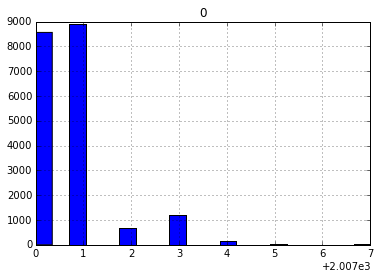

In [165]:
# 2007 and 2008 are especially bad. drop them from the analysis.
l = []
for i in output:
    l.append(i[2])
l = pd.DataFrame(l)
l.hist(bins=20)

In [208]:
cdf.drop_duplicates().CrimeCat.value_counts()

NONVIOLENT               91339
VIOLENT                  77919
VEHICLE_THEFT            55286
QUALITY                  55181
DOM-VIOL                 49611
OTHER                    48597
VEHICLE_BREAK_IN         38105
TRAFFIC_TOWED-VEHICLE    23050
WARRANT                  13564
TRAFFIC_MISDEMEANOR       4827
OTHER_MISSING-PERSON      3848
OTHER_RUNAWAY              386
dtype: int64

In [192]:
# Are categories now roughly stable over time?
# No.
# Which categories can be trusted?
# Quality, Vehicle_Theft, Vehicle_Break_In, Violent

# How did I determine what could be trusted? Look at drop for Dom-Viol
# Drop is really large. Remove from analysis and model
# on "reliable" data. This isn't cherry-picking per-se because we're
# only going to predict crime that we feel we can trust- we're not
# ignoring it, but we're not going to model it. Let's see how crime-we
# can-trust affects neighorhoods.

cdf.drop_duplicates().groupby(['CrimeCat','year']).Date.count()

CrimeCat              year
DOM-VIOL              2007     7263
                      2008     6955
                      2009     6859
                      2010     6549
                      2011     6465
                      2012     6527
                      2013     5839
                      2014     2809
                      2015      345
NONVIOLENT            2007    10942
                      2008    11337
                      2009    11041
                      2010    10916
                      2011    11589
                      2012    13378
                      2013    12099
                      2014     9083
                      2015      954
OTHER                 2007     7389
                      2008     7037
                      2009     7581
                      2010     7554
                      2011     6444
                      2012     6332
                      2013     5758
                      2014      456
                      2015       46
O

In [ ]:
# Look at Nonviolent to see if there are subcategories that dropped
# too much in 2014

# Do this on dataframe before mapping:
# cdf.drop_duplicates().groupby(['CrimeCat','year']).Date.count()

# Which labels I should drop entirely to stabilize Nonviolent crime?
# From above command:
# drop LARCENY_FRAUD, LARCENY_FORGERY_COUNTERFEIT
'''
Yearly data from 2007-2008 for LARCENY_FRAUD:
2007	1328
2008	1406
2009	1168
2010	749
2011	856
2012	1427
2013	1337
2014	652
'''
# drop LARCENY_FORGERY_COUNTERFEIT
'''
Yearly data from 2007-2014 for LARCENY_FORGERY_COUNTERFEIT:
2007	949
2008	828
2009	691
2010	794
2011	781
2012	776
2013	872
2014	22
'''